In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
def ecdf(data):
    x = np.sort(data)
    n = len(data)
    y = np.arange(1, len(x)+1)/n
    return x,y

In [4]:
sellers_data = pd.read_csv('../input/olist_sellers_dataset.csv')
product_cat = pd.read_csv('../input/product_category_name_translation.csv')
orders_dataset = pd.read_csv('../input/olist_orders_dataset.csv')
order_items_dataset = pd.read_csv('../input/olist_order_items_dataset.csv')
customers_dataset = pd.read_csv('../input/olist_customers_dataset.csv')
geolocation_dataset = pd.read_csv('../input/olist_geolocation_dataset.csv')
order_payments_dataset = pd.read_csv('../input/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('../input/olist_order_reviews_dataset.csv')
products_dataset = pd.read_csv('../input/olist_products_dataset.csv')




## Improve ETD accuracy

Improving ETD can be interpreted as:
    1. what is the states that has the lowest time delivery
    2. How does current ETD estimator reflects the true behaviour 

In [5]:
df_all = pd.merge(orders_dataset, customers_dataset, on='customer_id')
df_all = pd.merge(order_items_dataset, df_all, on='order_id')

In [6]:
df_all['order_purchase_timestamp'] = pd.to_datetime(df_all.order_purchase_timestamp)

In [23]:
clean_data = df_all.dropna()

clean_data['shipping_limit_date'] = pd.to_datetime(clean_data.shipping_limit_date)
clean_data['order_approved_at'] = pd.to_datetime(clean_data.order_approved_at)
clean_data['order_delivered_carrier_date'] = pd.to_datetime(clean_data.order_delivered_carrier_date)
clean_data['order_delivered_customer_date'] = pd.to_datetime(clean_data.order_delivered_customer_date)
clean_data['order_estimated_delivery_date'] = pd.to_datetime(clean_data.order_estimated_delivery_date)




convert to date time

In [64]:
clean_data['delta_ord_arrive_time'] = (clean_data.order_delivered_customer_date - clean_data.order_purchase_timestamp).dt.days
clean_data['delta_est_ord_arrive_time'] = (clean_data.order_estimated_delivery_date - clean_data.order_approved_at).dt.days
clean_data['delta_true_time_est_time'] = (clean_data.order_delivered_carrier_date - clean_data.order_estimated_delivery_date).dt.days

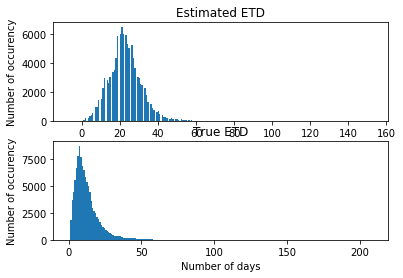

In [65]:
ETD_orders = clean_data.delta_est_ord_arrive_time.tolist()
True_EDT_orders = clean_data.delta_ord_arrive_time.tolist()

plt.subplot(2,1,1)
plt.title('Estimated ETD')
plt.xlabel('Number of days')
plt.ylabel('Number of occurency')
plt.hist(ETD_orders, bins=max(True_EDT_orders))

plt.subplot(2,1,2)
plt.title('True ETD')
plt.xlabel('Number of days')
plt.ylabel('Number of occurency')
plt.hist(True_EDT_orders, bins=max(True_EDT_orders))



plt.show()

It is kindly hard to say anything about this this, let's plot the ECDF for more details
1. how close they are
2. how much does it deviate



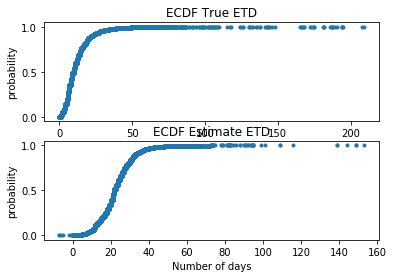

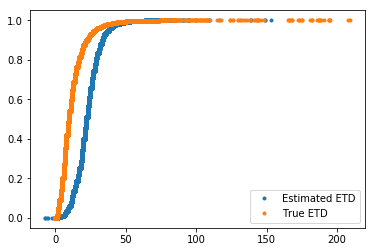

In [66]:
x_est_ETD, y_est_ETD = ecdf(ETD_orders)
x_ETD, y_ETD = ecdf(True_EDT_orders)


plt.plot()

plt.subplot(2,1,1)
plt.title('ECDF True ETD')
plt.xlabel('Number of days')
plt.ylabel('probability')
plt.plot(x_ETD,y_ETD, marker='.', linestyle='none')

plt.subplot(2,1,2)
plt.title('ECDF Estimate ETD')
plt.xlabel('Number of days')
plt.ylabel('probability')
plt.plot(x_est_ETD, y_est_ETD, marker='.', linestyle='none')

plt.show()


plt.plot(x_est_ETD, y_est_ETD, marker='.', linestyle='none')
plt.plot(x_ETD,y_ETD, marker='.', linestyle='none')

plt.legend(['Estimated ETD','True ETD'])
plt.show()




It looks like it is getting the right prediction only when the EST are greater than 40 days with probability of .89. 
But if we look deeper the model, this holds only for a limited number of states, not at all of them 

In [11]:
# states = clean_data.customer_state.unique().tolist()
# figures = []

# def plot_ecdf(df):
#     ETD_orders = df.delta_est_ord_arrive_time.tolist()
#     True_EDT_orders = df.delta_ord_arrive_time.tolist()
    
#     x_est_ETD, y_est_ETD = ecdf(ETD_orders)
#     x_ETD, y_ETD = ecdf(True_EDT_orders)
#     _ = plt.plot(x_ETD, y_ETD)
#     _ = plt.plot(x_est_ETD, y_est_ETD)
#     _ = plt.title('for {}'.format(df.customer_state.tolist()[-1]))
#     _ = plt.legend(['True ETD', 'EST ETD'])
    
#     _ = plt.show()
    
    

# for s in states:
#     plot_ecdf(clean_data[clean_data.customer_state == s])




Let's verify if any shops holidays are present like _new year_, _black friday_. Because for this day the amount of sold stuff is expected to be greater in these days than the rest days of a year

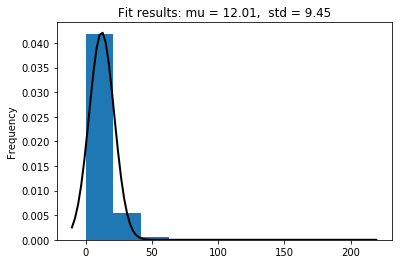

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  


clean_data.delta_ord_arrive_time.plot(kind='hist', normed=True)

mu, std = norm.fit(clean_data.delta_ord_arrive_time)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()


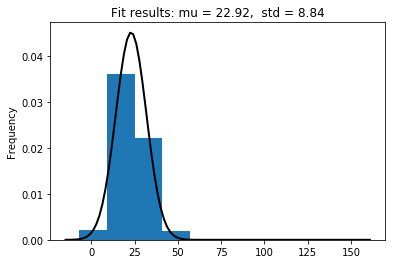

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm  


clean_data.delta_est_ord_arrive_time.plot(kind='hist', normed=True)

mu, std = norm.fit(clean_data.delta_est_ord_arrive_time)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()



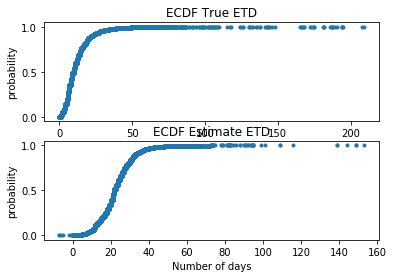

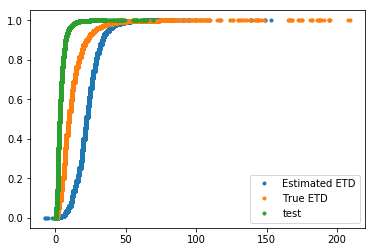

In [121]:
# test = clean_data.delta_est_ord_arrive_time/clean_data.delta_ord_arrive_time
test = clean_data.delta_ord_arrive_time / 3


x_est_ETD, y_est_ETD = ecdf(ETD_orders)
x_ETD, y_ETD = ecdf(True_EDT_orders)
x_t, y_t = ecdf(test)

plt.plot()

plt.subplot(2,1,1)
plt.title('ECDF True ETD')
plt.xlabel('Number of days')
plt.ylabel('probability')
plt.plot(x_ETD,y_ETD, marker='.', linestyle='none')

plt.subplot(2,1,2)
plt.title('ECDF Estimate ETD')
plt.xlabel('Number of days')
plt.ylabel('probability')
plt.plot(x_est_ETD, y_est_ETD, marker='.', linestyle='none')

plt.show()


plt.plot(x_est_ETD, y_est_ETD, marker='.', linestyle='none')
plt.plot(x_ETD,y_ETD, marker='.', linestyle='none')
plt.plot(x_t,y_t, marker='.', linestyle='none')

plt.legend(['Estimated ETD','True ETD', 'test'])
plt.show()





Since we are trying to make prediction about the true ETD, we have to drop the their model data column

In [68]:
import sklearn

I stick with the following features: ['shipping_limit_date', 'price', 'freight_value', 'customer_zip_code_prefix','customer_state']

At first: if an item hasn't been shipped till the limit dates there is no point to wait for that item at all, 
second the price and shipping price of an item have influence on shipping cost and client budget

In [69]:
zip_codes = clean_data.customer_zip_code_prefix.unique().tolist()
custome_state = clean_data.customer_state.unique().tolist()

clean_data['customer_zip_code_prefix'] = pd.Categorical(clean_data['customer_zip_code_prefix'], categories = zip_codes, ordered=False)
clean_data['customer_state'] = pd.Categorical(clean_data['customer_state'], categories=custome_state, ordered=False)



In [70]:
clean_data['shipping_limit_date'] = clean_data.shipping_limit_date.dt.day

AttributeError: Can only use .dt accessor with datetimelike values

In [71]:
clean_data[['shipping_limit_date', 'price', 'freight_value', 'customer_zip_code_prefix','customer_state', 'delta_ord_arrive_time']].head(10)

,shipping_limit_date,price,freight_value,customer_zip_code_prefix,customer_state,delta_ord_arrive_time
0,19,58.90,13.29,28013,RJ,7
1,3,239.90,19.93,15775,SP,16
2,18,199.00,17.87,35661,MG,7
3,15,12.99,12.79,12952,SP,6
4,13,199.90,18.14,13226,SP,25
5,23,21.90,12.69,38017,MG,6
6,14,19.90,11.85,16700,SP,8
7,10,810.00,70.75,11702,SP,5
8,26,145.95,11.65,11075,SP,9
9,6,53.99,11.40,6636,SP,2


In [81]:
# train_data = clean_data[['shipping_limit_date', 'price', 'freight_value', 'customer_zip_code_prefix','customer_state', 'delta_ord_arrive_time']].copy()
train_data = clean_data[['shipping_limit_date', 'price', 'freight_value', 'customer_zip_code_prefix','customer_state', 'delta_ord_arrive_time', 'delta_est_ord_arrive_time']].copy()
# y = train_data['delta_ord_arrive_time']
y = train_data['delta_est_ord_arrive_time']




In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.3)

selected_columns = X_train.columns.difference(\
                                              ['customer_zip_code_prefix','customer_state', 'delta_est_ord_arrive_time','delta_ord_arrive_time'])

lm = LinearRegression(n_jobs=-1)
lm.fit(X_train[selected_columns], y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [83]:
ynew = lm.predict(X_test[selected_columns])

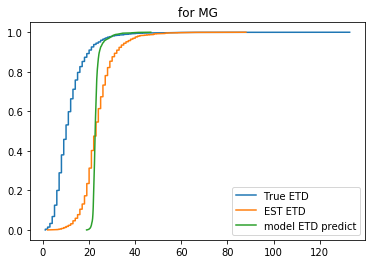

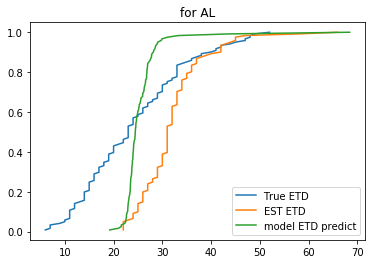

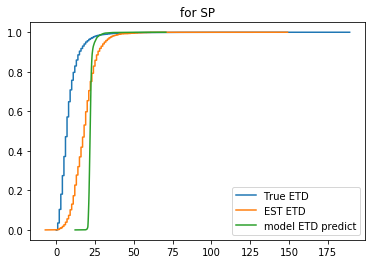

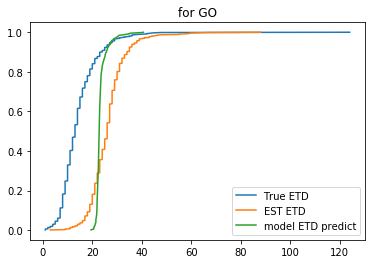

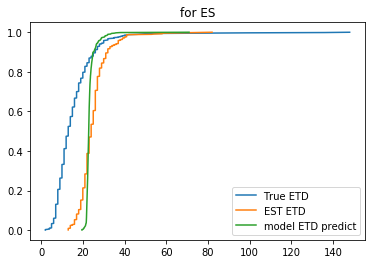

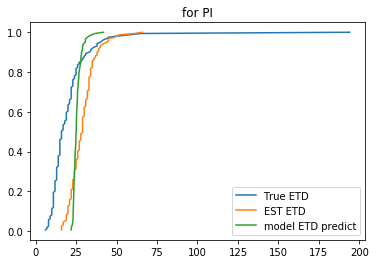

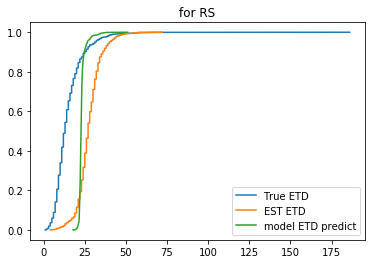

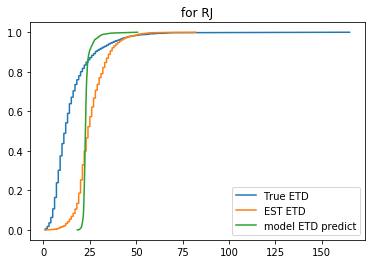

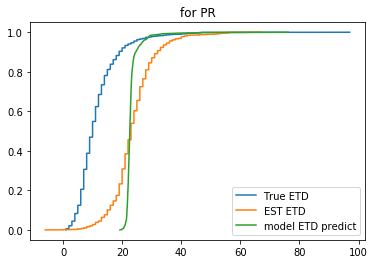

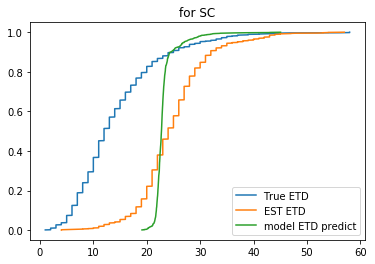

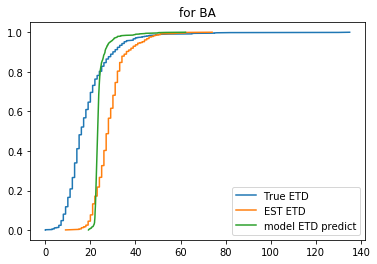

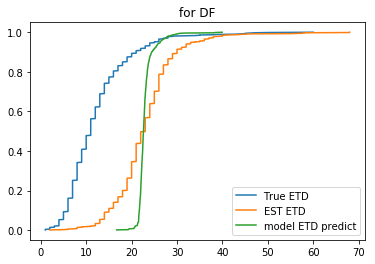

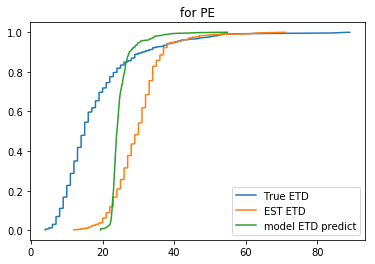

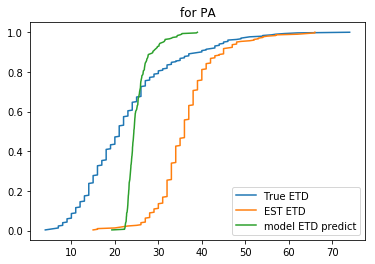

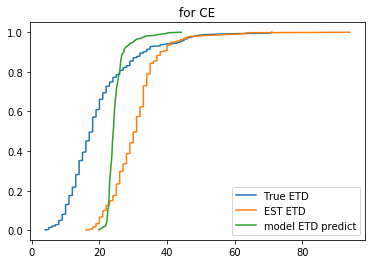

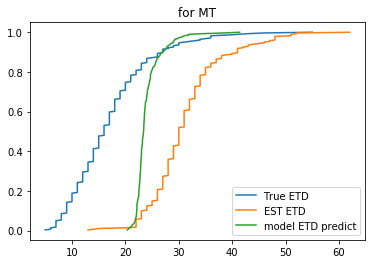

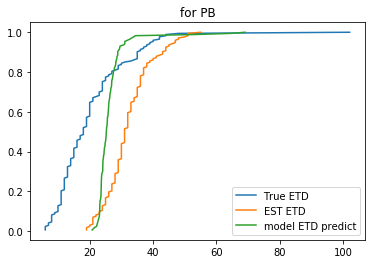

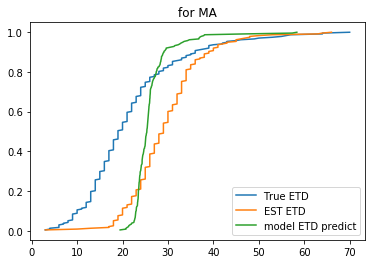

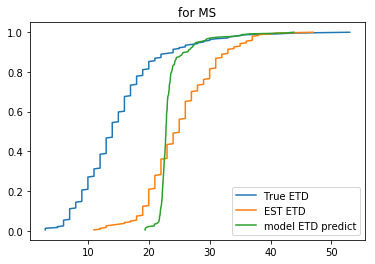

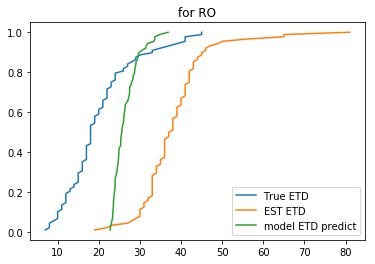

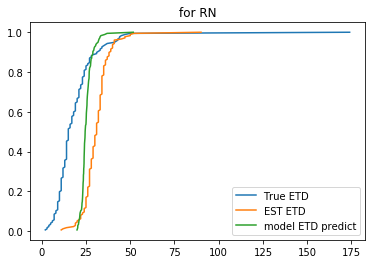

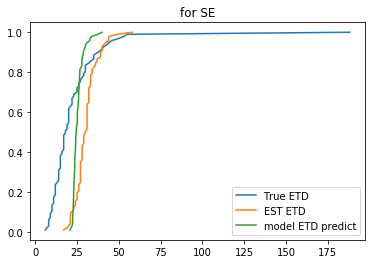

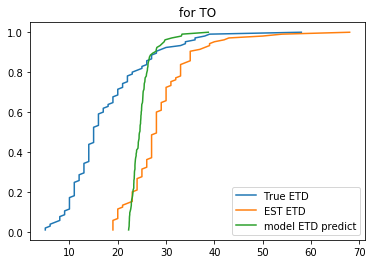

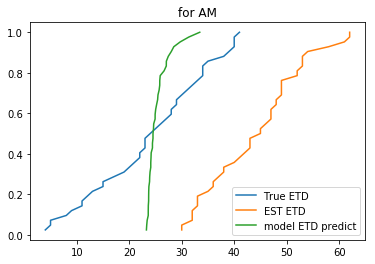

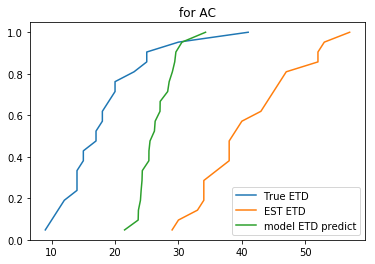

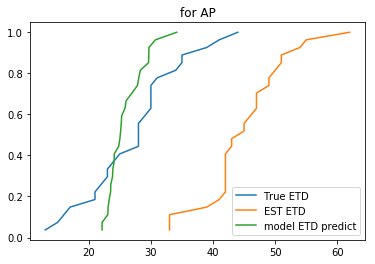

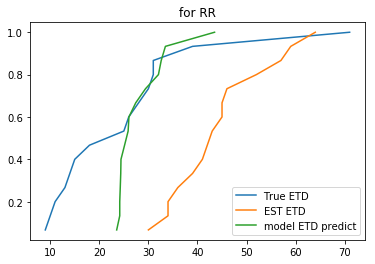

In [84]:
X_test['our_model_predict'] = ynew


def plot_ecdf(df):
    ETD_orders = df.delta_est_ord_arrive_time.tolist()
    True_EDT_orders = df.delta_ord_arrive_time.tolist()
    model_ETD_orders = df.our_model_predict.tolist()
    
    x_est_ETD, y_est_ETD = ecdf(ETD_orders)
    x_ETD, y_ETD = ecdf(True_EDT_orders)
    x_model_ETD, y_model_ETD = ecdf(model_ETD_orders)
    
    _ = plt.plot(x_ETD, y_ETD)
    _ = plt.plot(x_est_ETD, y_est_ETD)
    _ = plt.plot(x_model_ETD, y_model_ETD)
    _ = plt.title('for {}'.format(df.customer_state.tolist()[-1]))
    _ = plt.legend(['True ETD', 'EST ETD', 'model ETD predict'])
    
    _ = plt.show()
    

    
def draw_ecdf_models(df):
    states = X_test.customer_state.unique().tolist()  

    for s in states:
        plot_ecdf(df[clean_data.customer_state == s])

    

draw_ecdf_models(X_test)


let's plot the ECDF and see how closely to the truth shape they are. It looks that our model is worst than an existing one. Let's try different way

In [123]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 3, n_jobs = -1, random_state = 7, verbose = 1)

rfr.fit(X_train[selected_columns], y_train)
ynew = rfr.predict(X_test[selected_columns])



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


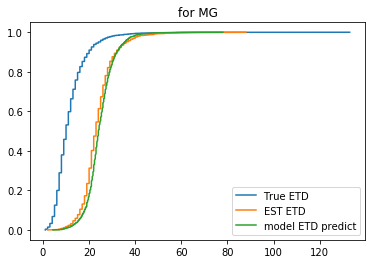

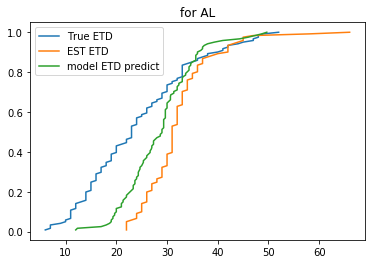

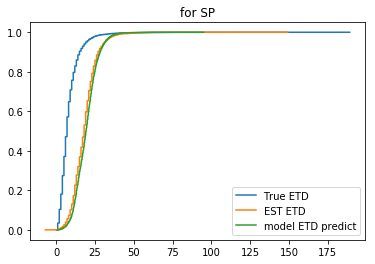

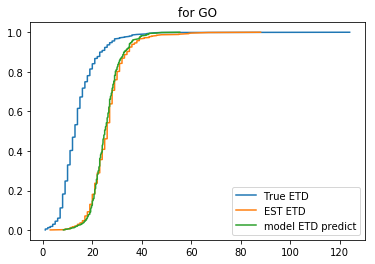

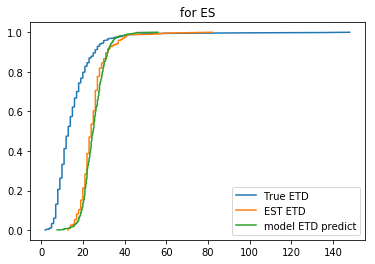

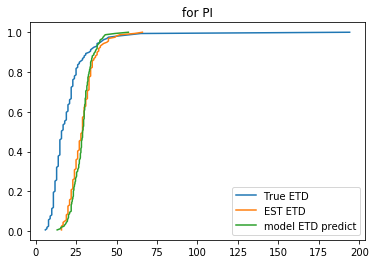

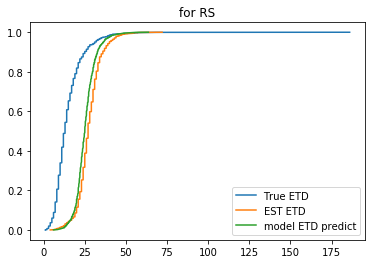

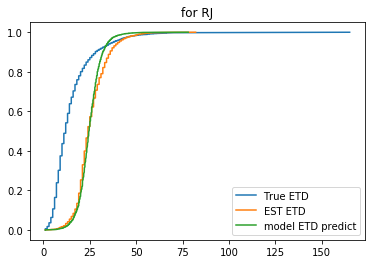

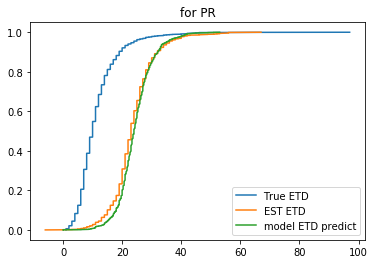

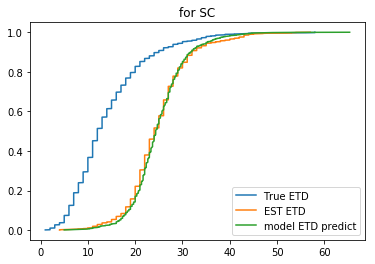

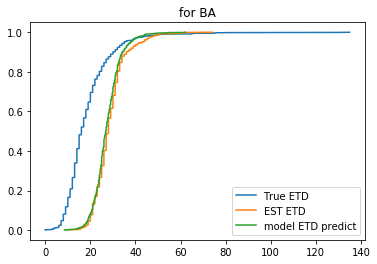

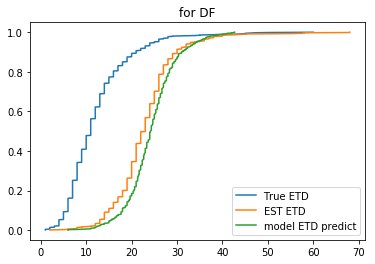

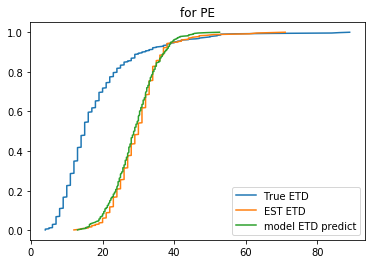

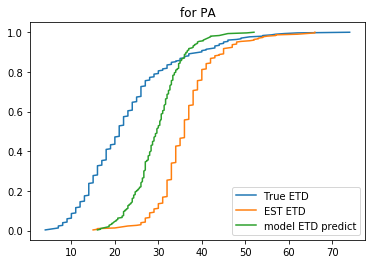

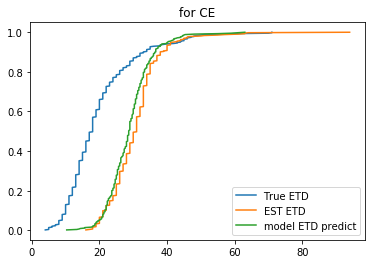

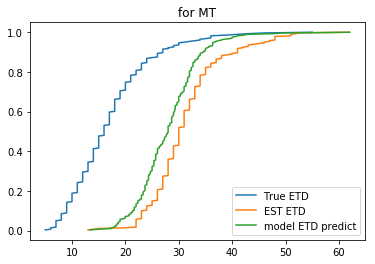

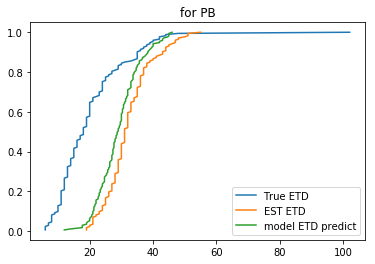

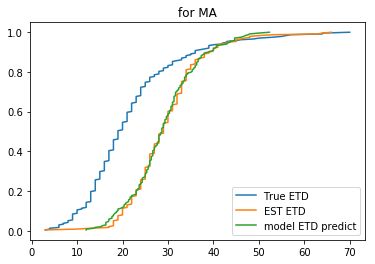

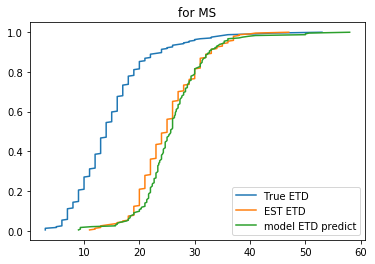

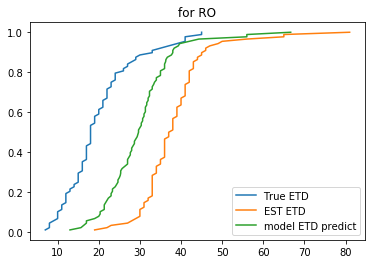

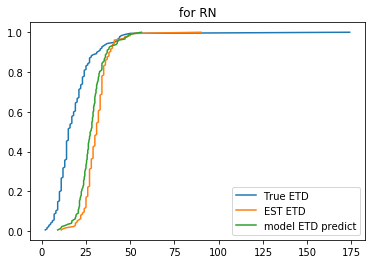

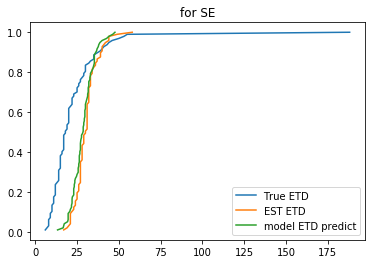

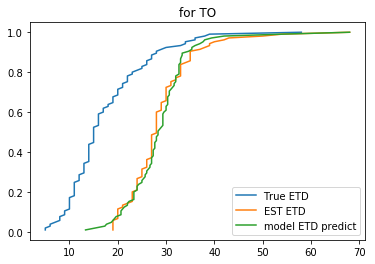

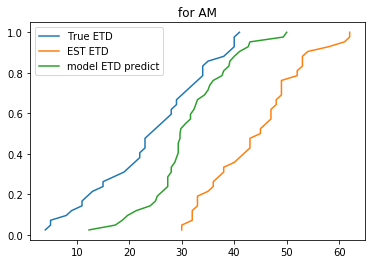

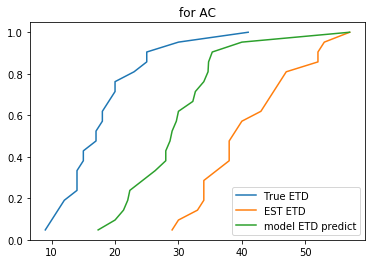

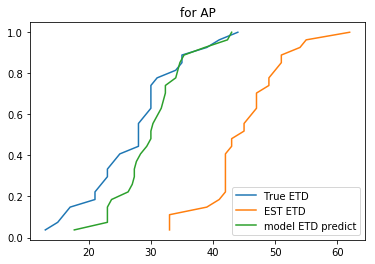

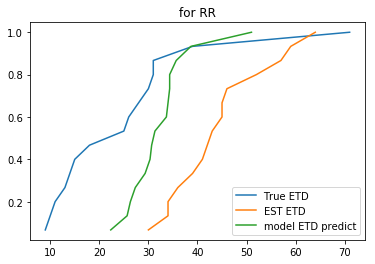

In [124]:
X_test['our_model_predict'] = ynew

draw_ecdf_models(X_test)


Now It looks even better our prediction, but before making any judgement about this we have to assure that the following criteria holds:
- our model aren't overfitting/underfitting the data
From above ECDF plots we can conclude that the model is making too early prediction which might cause lossing money 
due to delay/latency till the order received at postal office.

Ways to improve model
 - We might achieve even better performance by approximating the delivery function with any know distribution 
 - Try to tune the parametters
 - Dive deeper to those states where model ETD is performing bad, and try to grab conclusion from the dataset for that criteria
 - Try to use any timeseries alogirithms 

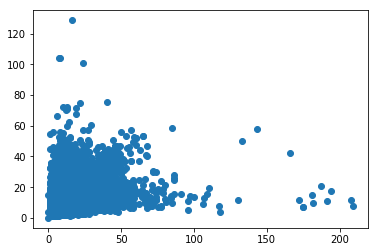

In [79]:
plt.scatter(y_test, ynew)

##  Pick better fulfillment plans, better meaning "faster" or "cheaper"


In [ ]:
# code goes below
# find the min of time which takes to an item to arrive

## Improve conversion and maximize revenue by dynamically pricing premium delivery options for loyal customers

In [ ]:
# code goes below

In [ ]:
# reference https://www.kaggle.com/lukio43/a-simple-analysis-of-delayed-orders